In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 6.5.1 Best Subset Selection

Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year. Let's take a quick look:

In [4]:
hitters_df = pd.read_csv('../data/Hitters.csv')
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


First of all, we note that the `Salary` variable is missing for some of the
players. The `isnull()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `TRUE` value
for any elements that are missing, and a `FALSE` value for non-missing elements.
The `sum()` function can then be used to count all of the missing elements:

In [5]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

Number of null values: 59


We see that `Salary` is missing for 59 players. The `dropna()` function
removes all of the rows that have missing values in any variable:

In [6]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df_clean = hitters_df.dropna().drop('League', axis=1).drop('Division', axis=1).drop('NewLeague', axis=1)

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 20)
Dimensions of modified data: (263, 17)
Number of null values: 0


In [7]:

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X = hitters_df_clean.drop(['Salary'], axis=1)


We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RSS. We'll define a helper function to outputs the best set of variables for
each model size:

In [8]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [9]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [10]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 16 models on 1 predictors in 0.01259303092956543 seconds.
Processed 120 models on 2 predictors in 0.046568870544433594 seconds.
Processed 560 models on 3 predictors in 0.16105890274047852 seconds.
Processed 1820 models on 4 predictors in 0.56479811668396 seconds.
Processed 4368 models on 5 predictors in 1.3740170001983643 seconds.
Processed 8008 models on 6 predictors in 2.511817216873169 seconds.
Processed 11440 models on 7 predictors in 3.764551877975464 seconds.
Total elapsed time: 8.498820781707764 seconds.


Now we have one big `DataFrame` that contains the best models we've generated along with their RSS:

In [11]:
models_best

,RSS,model
1,43213925.909868,<statsmodels.regression.linear_model.Regressio...
2,30733054.433644,<statsmodels.regression.linear_model.Regressio...
3,29438536.051764,<statsmodels.regression.linear_model.Regressio...
4,28260738.936139,<statsmodels.regression.linear_model.Regressio...
5,27187795.009508,<statsmodels.regression.linear_model.Regressio...
6,26849868.013577,<statsmodels.regression.linear_model.Regressio...
7,26145894.016576,<statsmodels.regression.linear_model.Regressio...


If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [13]:
print(models_best.loc[3, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.769
Method:                 Least Squares   F-statistic:                              292.7
Date:                Fri, 21 Feb 2025   Prob (F-statistic):                    5.01e-83
Time:                        11:45:21   Log-Likelihood:                         -1902.0
No. Observations:                 263   AIC:                                      3810.
Df Residuals:                     260   BIC:                                      3821.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

This output indicates that the best two-variable model
contains only `Hits` and `CRBI`. To save time, we only generated results
up to the best 7-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [17]:
# Show the best 19-variable model (there's actually only one)
print(getBest(16)["model"].summary())

Processed 1 models on 16 predictors in 0.0020189285278320312 seconds.
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.803
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              62.87
Date:                Fri, 21 Feb 2025   Prob (F-statistic):                    1.90e-77
Time:                        11:45:41   Log-Likelihood:                         -1882.6
No. Observations:                 263   AIC:                                      3797.
Df Residuals:                     247   BIC:                                      3854.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P

Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [18]:
models_best.loc[2, "model"].rsquared

0.7614950002332873

Excellent! In addition to the verbose output we get when we print the summary to the screen, fitting the `OLM` also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [19]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

/var/folders/s4/35mz08191h37fr7zq4g0m_d40000gn/T/ipykernel_75491/3287597919.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  models_best.apply(lambda row: row[1].rsquared, axis=1)


1    0.664637
2    0.761495
3    0.771541
4    0.780681
5    0.789008
6    0.791631
7    0.797094
dtype: float64

As expected, the $R^2$ statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. Note the `type="l"` option tells `R` to
connect the plotted points with lines:

/var/folders/s4/35mz08191h37fr7zq4g0m_d40000gn/T/ipykernel_75491/3408317970.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)
/var/folders/s4/35mz08191h37fr7zq4g0m_d40000gn/T/ipykernel_75491/3408317970.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aic = models_best.apply(lambda row: row[1].aic, axis=1)
/var/folders/s4/35mz08191h37fr7zq4g0m_d40000gn/T/ipykernel_75491/3408317970.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consisten

Text(0, 0.5, 'BIC')

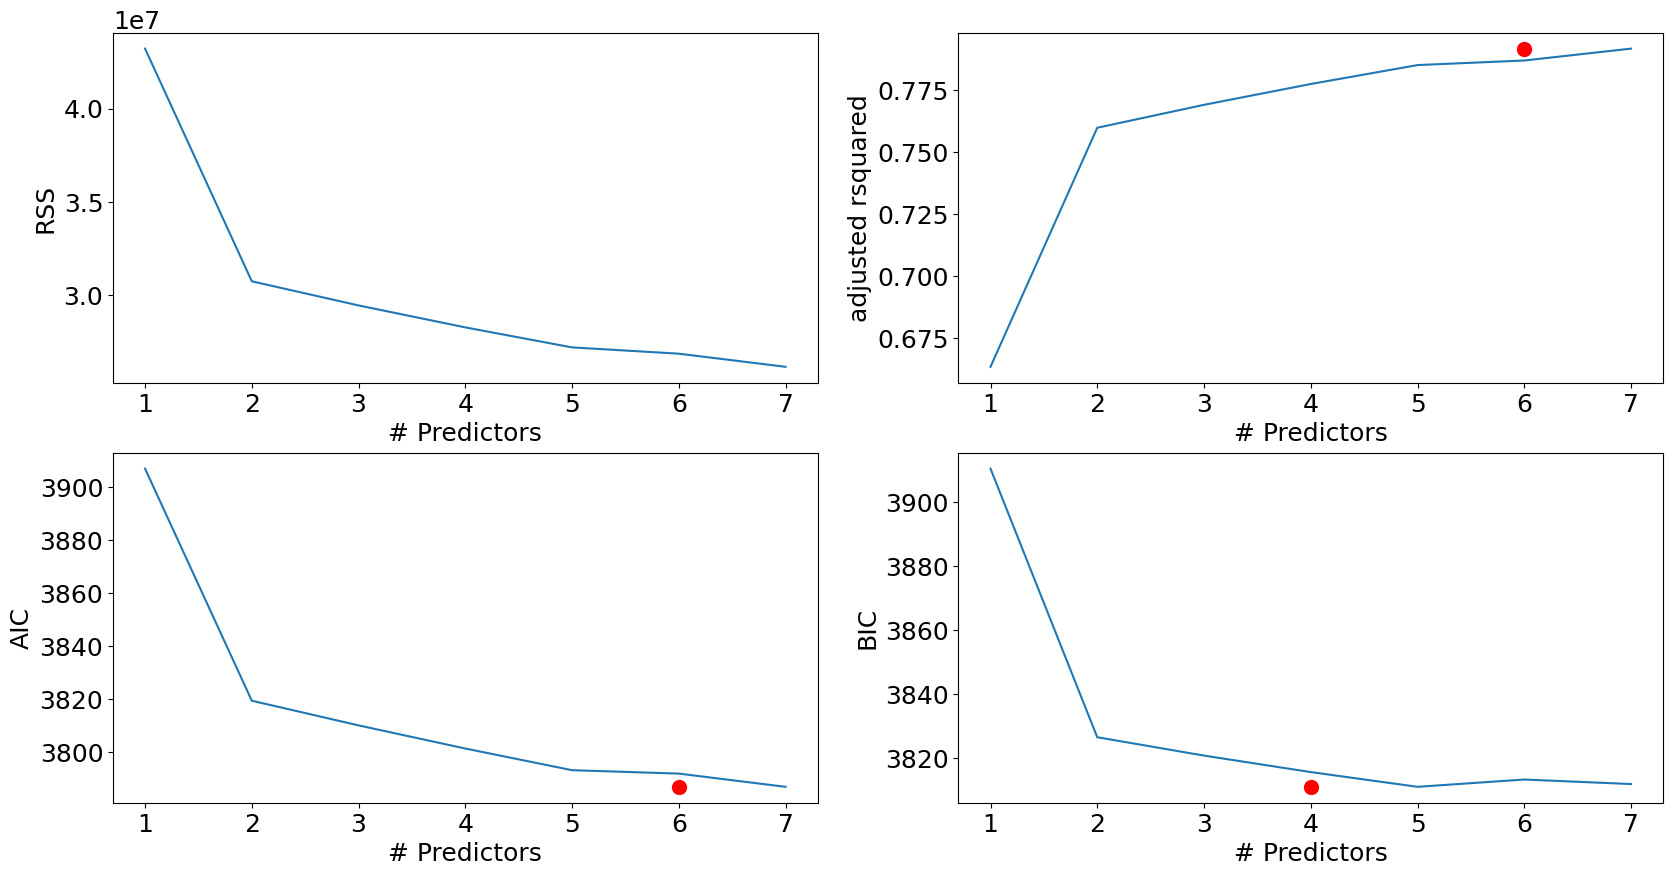

In [20]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted $R^2$ something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

# 6.5.2 Forward and Backward Stepwise Selection
We can also use a similar approach to perform forward stepwise
or backward stepwise selection, using a slight modification of the functions we defined above:

In [21]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

Now let's see how much faster it runs!

In [22]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  16 models on 1 predictors in 0.013567924499511719 seconds.
Processed  15 models on 2 predictors in 0.008838176727294922 seconds.
Processed  14 models on 3 predictors in 0.006350278854370117 seconds.
Processed  13 models on 4 predictors in 0.005632877349853516 seconds.
Processed  12 models on 5 predictors in 0.0049321651458740234 seconds.
Processed  11 models on 6 predictors in 0.004454851150512695 seconds.
Processed  10 models on 7 predictors in 0.004047870635986328 seconds.
Processed  9 models on 8 predictors in 0.003493785858154297 seconds.
Processed  8 models on 9 predictors in 0.003183126449584961 seconds.
Processed  7 models on 10 predictors in 0.0027608871459960938 seconds.
Processed  6 models on 11 predictors in 0.0024261474609375 seconds.
Processed  5 models on 12 predictors in 0.002073049545288086 seconds.
Processed  4 models on 13 predictors in 0.0017850399017333984 seconds.
Processed  3 models on 14 predictors in 0.0013439655303955078 seconds.
Processed  2 models 

Phew! That's a lot better. Let's take a look:

In [23]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.665
Model:                            OLS   Adj. R-squared (uncentered):              0.663
Method:                 Least Squares   F-statistic:                              519.2
Date:                Fri, 21 Feb 2025   Prob (F-statistic):                    4.20e-64
Time:                        11:46:18   Log-Likelihood:                         -1952.4
No. Observations:                 263   AIC:                                      3907.
Df Residuals:                     262   BIC:                                      3910.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We see that using forward stepwise selection, the best one-variable
model contains only `Hits`, and the best two-variable model additionally
includes `CRBI`. Let's see how the models stack up against best subset selection:

In [24]:
print(models_best.loc[6, "model"].summary())
print(models_fwd.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.792
Model:                            OLS   Adj. R-squared (uncentered):              0.787
Method:                 Least Squares   F-statistic:                              162.7
Date:                Fri, 21 Feb 2025   Prob (F-statistic):                    1.57e-84
Time:                        11:46:21   Log-Likelihood:                         -1889.9
No. Observations:                 263   AIC:                                      3792.
Df Residuals:                     257   BIC:                                      3813.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.

# Backward Selection
Not much has to change to implement backward selection... just looping through the predictors in reverse!

In [25]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.
However, the best seven-variable models identified by forward stepwise selection,
backward stepwise selection, and best subset selection are different:

In [26]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

------------
Best Subset:
------------
AtBat     -2.037923
Hits       7.393757
Walks      5.979784
CHmRun     1.148685
CRuns      0.946555
CWalks    -0.763997
PutOuts    0.296954
dtype: float64


In [ ]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

In [ ]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)